<a href="https://colab.research.google.com/github/MohuaSinha/EVA4/blob/master/S15B/S15B_Trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import time
import glob
import torch
import os

from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [0]:
#Extract data
import zipfile
#for i in range(5):
archive = zipfile.ZipFile(f'/content/gdrive/My Drive/Colab Notebooks/EVA4/S14_15/DenseDepth_FinalDataset/image_dataset_full.zip')
archive.extractall()

In [4]:
!du -h  --apparent-size "/content/dataset" # human understandable form

481M	/content/dataset/depthmap
1.5M	/content/dataset/fg
516M	/content/dataset/mask
844K	/content/dataset/fg_mask
2.1M	/content/dataset/bg
2.5G	/content/dataset/image
3.5G	/content/dataset


In [0]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch import nn
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np

data_root=Path('/content/dataset/')

In [0]:
f1,f2,f3=data_root/'image',data_root/'bg',data_root/'mask'
#print(len(list(f1.iterdir())))
#print(len(list(f2.iterdir())))
#f1=list(f1.iterdir())
#f2=list(f2.iterdir())
#f3=list(f3.iterdir())
#print((list(f3.iterdir())))
#print(f1[0])
#print(f2[0])
#print(f3[0])

In [0]:
scale_transform=transforms.Compose([transforms.Resize(256,256),transforms.ToTensor(),])

In [0]:
fg_bg_name   = f1_files[0].stem
fg_bg_idx    = fg_bg_name.split('_')[-1]
print(fg_bg_idx)

In [0]:
class MasterDataset(Dataset): 
   def __init__(self,data_root,transform=None):
     self.f1_files=list(f1.glob('*.jpg'))
     self.f2_files=list(f2.glob('*.jpg'))
     self.f3_files=list(f3.glob('*.jpg'))
     self.path='/content/dataset/'

     self.transform=transform
   def __len__(self):
     return len(self.f1_files)
     
   def __getitem__(self,index):
     new_index=index+1
     if new_index%4000==0:
       bg_index=int(new_index/4000)
     else:
       bg_index=int(new_index/4000)+1
     bg=Image.open(self.path+'bg/bg_'+str(bg_index)+'.jpg')  
     fgbg=Image.open(self.path+'image/fg_bg_'+str(new_index)+'.jpg')  
     mask=Image.open(self.path+'mask/fg_bg_mask_'+str(new_index)+'.jpg')  

     if self.transform:
       tr = transforms.ToTensor()
       f1_image=tr(fgbg)
       f2_image=tr(bg)
       f3_image=tr(mask)

     return {'f1':f1_image,'f2':f2_image,'f3':f3_image}

In [0]:
train_transforms=transforms.Compose([
    #[transforms.Resize(256,256),
                                     transforms.ToTensor(),])

In [0]:
train_ds=MasterDataset(data_root,train_transforms)

In [0]:
#from PIL import Image
#[(k,v.shape) for k,v in train_ds[0].items()]

In [0]:
train_dl=DataLoader(train_ds,batch_size=16,shuffle=True,pin_memory=True)

In [0]:
sample=next(iter(train_dl))

In [16]:
type(sample)
#print(sample)

dict

In [0]:
[(k,v.shape) for k,v in sample.items()]

In [0]:
imgs = sample['f1']
imgs2=sample['f2']
imgs3=sample['f3']
sample['f3'].shape


In [0]:
#grid_tensor=torchvision.utils.make_grid(imgs,2)

In [0]:
#grid_image=grid_tensor.permute(1,2,0)

In [0]:
def show(tensors,figsize=(10,10),*args,**kwargs):
  try:
    tensors=tensors.detach.cpu()
  except:
    pass

  grid_tensor=torchvision.utils.make_grid(tensors,*args,**kwargs)
  grid_image=grid_tensor.permute(1,2,0)
  plt.figure(figsize=figsize)
  plt.imshow(grid_image)
  plt.xticks([])
  plt.yticks([])
  plt.show()  

In [0]:
def show_pred(tensors,*args,**kwargs):
  tensors=(tensors* std[None,:,None,None]) +mean[None,:,None,None]
  show(tensors,*args,**kwargs)

In [0]:
show(imgs,nrow=4)
#show(imgs2,nrow=4)
show(imgs3,nrow=4)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
%cd "//content/gdrive/My Drive/Colab Notebooks/EVA4/ipynb"
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/ipynb'
sys.path.append(workingdir)

In [0]:
ls-ltr

In [0]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3,32,3,stride=1,padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) 
        # Convolution Block 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(32,32,3,stride=1, padding=1, bias=False),
            nn.Conv2d(32,64,1,stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 

        self.convblock3 = nn.Sequential(
            nn.Conv2d(128,256,3,stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()           
        ) 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(256,3,3,stride=1, padding=1, bias=False),
                      
        ) 

    def forward(self,sample):
       
       #f1 = sample   
       #f2 = sample
       f1=sample['f1']
       f2=sample['f2']

       f1 = self.convblock2(self.convblock1(f1))
       f2 = self.convblock2(self.convblock1(f2))

       f = torch.cat([f1,f2], dim=1)
       f = self.convblock4(self.convblock3(f))

       return f

In [20]:
f1=sample['f1']
f2=sample['f2']
f = torch.cat([f1,f2], dim=1)
type(f1)
type(f2)
type(f)

torch.Tensor

In [0]:
class CustomNet1(nn.Module):
    def __init__(self):
        super(CustomNet1, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3,10,3,stride=1,padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) 
        # Convolution Block 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(10,10,3,stride=1, padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) 

        self.convblock3 = nn.Sequential(
            nn.Conv2d(10,20,3,stride=1, padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()           
        ) 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(20,10,1,stride=1, padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()          
        ) 

        self.pool1=nn.MaxPool2d(2,2)

        self.convblock5 = nn.Sequential(
            nn.Conv2d(10,10,3,stride=1, padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()          
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(10,20,3,stride=1, padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()          
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(20,20,3,stride=1, padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()          
        )
        
        self.gap = nn.Sequential (
            nn.AvgPool2d(kernel_size=5)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(20,10,1,stride=1, padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()          
        )
       
        self.convblock9 = nn.Sequential(
            nn.Conv2d(10,10,1,stride=1, padding=0, bias=False),
                  
        )

    def forward(self,x,y):
        
        # Input Block
        f1 = self.convblock3(self.convblock2(self.convblock1(x)))     
        f1 = self.pool1(f1)
        f1 = self.convblock7(self.convblock6(self.convblock5(self.convblock4(f1))))
        f1 = self.gap(f1)
        f1 = self.convblock9(self.convblock8(f1))

        f2 = self.convblock3(self.convblock2(self.convblock1(y)))     
        f2 = self.pool1(f2)
        f2 = self.convblock7(self.convblock6(self.convblock5(self.convblock4(f2))))
        f2 = self.gap(f2)
        f2 = self.convblock9(self.convblock8(f2))        
               
        # Output Block 
        f=torch.cat([f1,f2],dim=1) 
        

        
        return f

In [30]:
model    = CustomNet()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

CustomNet(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convblock3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock4): Sequential(
    (0): Conv2d(256, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [0]:
from torchsummary import summary
summary(model, input_size=(3,220,220))

In [0]:
import dnnmodel
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = CustomNet()
#model(inputs.permute(0, 3, 1, 2))

model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
print(model.device)
#print(model)
#summary(model,[(3, 220, 220),(3, 220, 220)])
summary(model,input_size=(3, 220, 220))

In [0]:
optim = torch.optim.SGD(model.parameters(),lr=0.01, momentum = 0.9, weight_decay = 1e-5)

In [0]:
pwd

In [0]:
PATH = Path('./saved_models/')
PATH.mkdir(exist_ok=True)

In [24]:
PATH = '/content/gdrive/My Drive/Colab Notebooks/EVA4/ipynb/saved_models/'
print(PATH)
model = CustomNet()
model.load_state_dict(torch.load(PATH + '1000UsedOne.pth'))

/content/gdrive/My Drive/Colab Notebooks/EVA4/ipynb/saved_models/


FileNotFoundError: ignored

In [0]:
def train(model, criterion, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, data in enumerate(train_loader):
    data['f1'] = data['f1'].to(device)
    data['f2'] = data['f2'].to(device)
    data['f3'] = data['f2'].to(device)
    
    optimizer.zero_grad()
    output = model(data)

 # breakpoint()

    loss = criterion(output, data['f3'])   
    loss.backward()
    optimizer.step()
    if batch_idx % 500 == 0:
      print(time())
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
      print('Batch ID:', batch_idx)

    if batch_idx % 500 == 0:
      #show_pred(output.detach().cpu(), nrow =2) # nrow = sqrt-bs
      print(time())
      show(output.detach().cpu(),nrow = 8)   # nrow = sqrt-bs

    #if batch_idx % 500 == 0:  
    #  torch.save(model.state_dict(),PATH/f'{batch_idx}.pth')

In [0]:
def test(model, criterion, device, test_loader):
  model.eval()
  test_loss = 0
  #correct = 0
  with torch.no_grad():
    for data in test_loader:
      data['f1'] = data['f1'].to(device)
      data['f2'] = data['f2'].to(device)
      data['f3'] = data['f3'].to(device)
      output = model(data)

      test_loss = criterion(output, data['f3'], reduction='sum').item()  #sum up batch loss
      #pred = output.argmax(dim=1, keepdim = True) # get the index of max-log probability
      #correct += pred.eq(target.view_as(pred)).sum().item()

      show(output.cpu(), nrow=8) # nrow = sqrt-bs

  test_loss /= len(test_loader.dataset)

In [0]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size =1, gamma = 0.01)
#criterion = SSIM(kernel_size, reduction = 'mean)
criterion = nn.BCEWithLogitsLoss()

1590323683.618154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [0/400000 (0%)]	Loss: 0.697334
Batch ID: 0
1590323684.550459


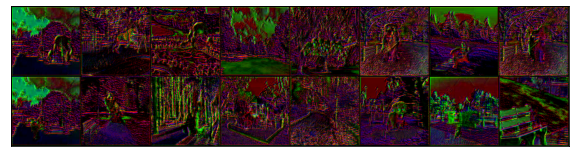

1590324115.787497


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [1500/400000 (2%)]	Loss: 0.698199
Batch ID: 500
1590324116.6576521


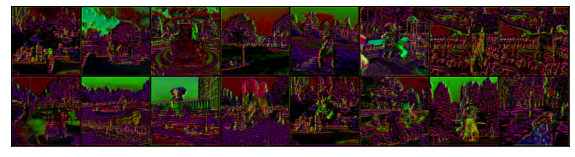

1590324547.076217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [3000/400000 (4%)]	Loss: 0.700466
Batch ID: 1000
1590324547.941513


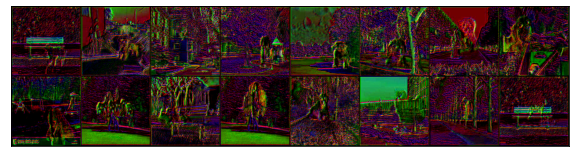

1590324978.4644039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [4500/400000 (6%)]	Loss: 0.701869
Batch ID: 1500
1590324979.3324618


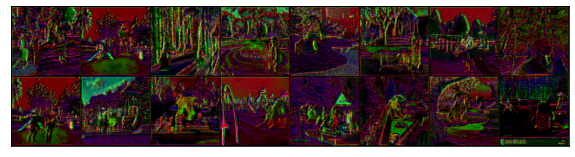

1590325409.6950617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [6000/400000 (8%)]	Loss: 0.697383
Batch ID: 2000
1590325410.56689


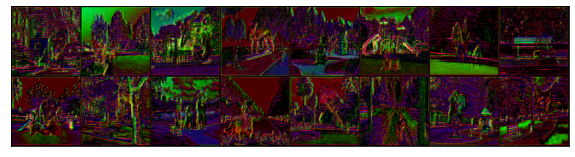

1590325841.159103


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [7500/400000 (10%)]	Loss: 0.697431
Batch ID: 2500
1590325842.022836


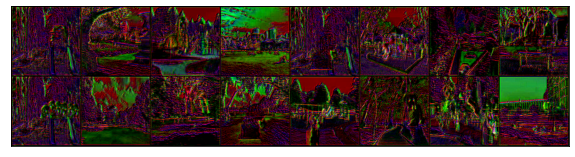

1590326272.4435008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [9000/400000 (12%)]	Loss: 0.697005
Batch ID: 3000
1590326273.318819


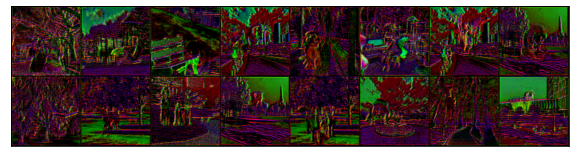

1590326704.000493


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [10500/400000 (14%)]	Loss: 0.695236
Batch ID: 3500
1590326704.875465


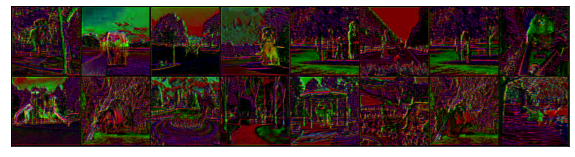

1590327133.585247


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [12000/400000 (16%)]	Loss: 0.698356
Batch ID: 4000
1590327134.4532495


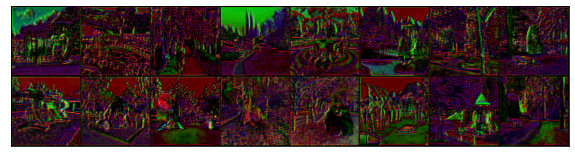

1590327564.5851839


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [13500/400000 (18%)]	Loss: 0.697443
Batch ID: 4500
1590327565.4610765


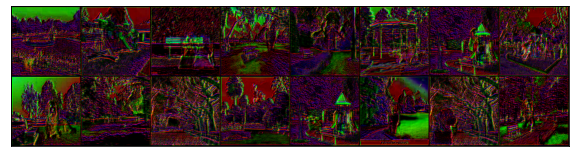

1590327996.0315428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [15000/400000 (20%)]	Loss: 0.698510
Batch ID: 5000
1590327996.9120069


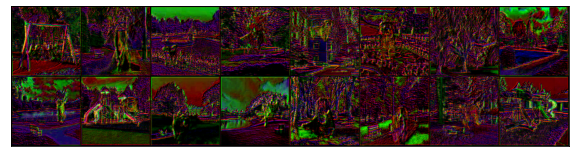

In [0]:
from time import time
from datetime import datetime 

for epoch in range(1,2):
  train(model, criterion,model.device, train_dl, optim, epoch)
  #test(model, device, test_loader)
  scheduler.step()